MAILLAGES GÉOGRAPHIQUES DE PARIS

1. Pour charger les arrondissements :
   arr = get_arrondissements_paris()

2. Pour charger les quartiers :
   qua = get_quartiers_paris()

3. Pour charger les IRIS (recommandé pour analyses fines) :
   iris = get_iris_paris()

4. Pour le carroyage 200m (très détaillé) :
   car_200m = get_carroyage_200m_paris()

5. Pour le carroyage 1km (intermédiaire) :
   car_1km = get_carroyage_1km_paris()

6. Pour visualiser tous les maillages :
   visualiser_maillages()

RECOMMANDATIONS PAR CAS D'USAGE
• Analyse macro / Communication : Arrondissements (20)
• Analyse intermédiaire : Quartiers (80)
• Analyse fine / Sociodémographie : IRIS (~1000)
• Analyse ultra-fine / Urbanisme : Carroyage 200m
• Grille régulière neutre : Carroyage 200m ou 1km

1/5 Chargement des arrondissements...


NameError: name 'arr' is not defined

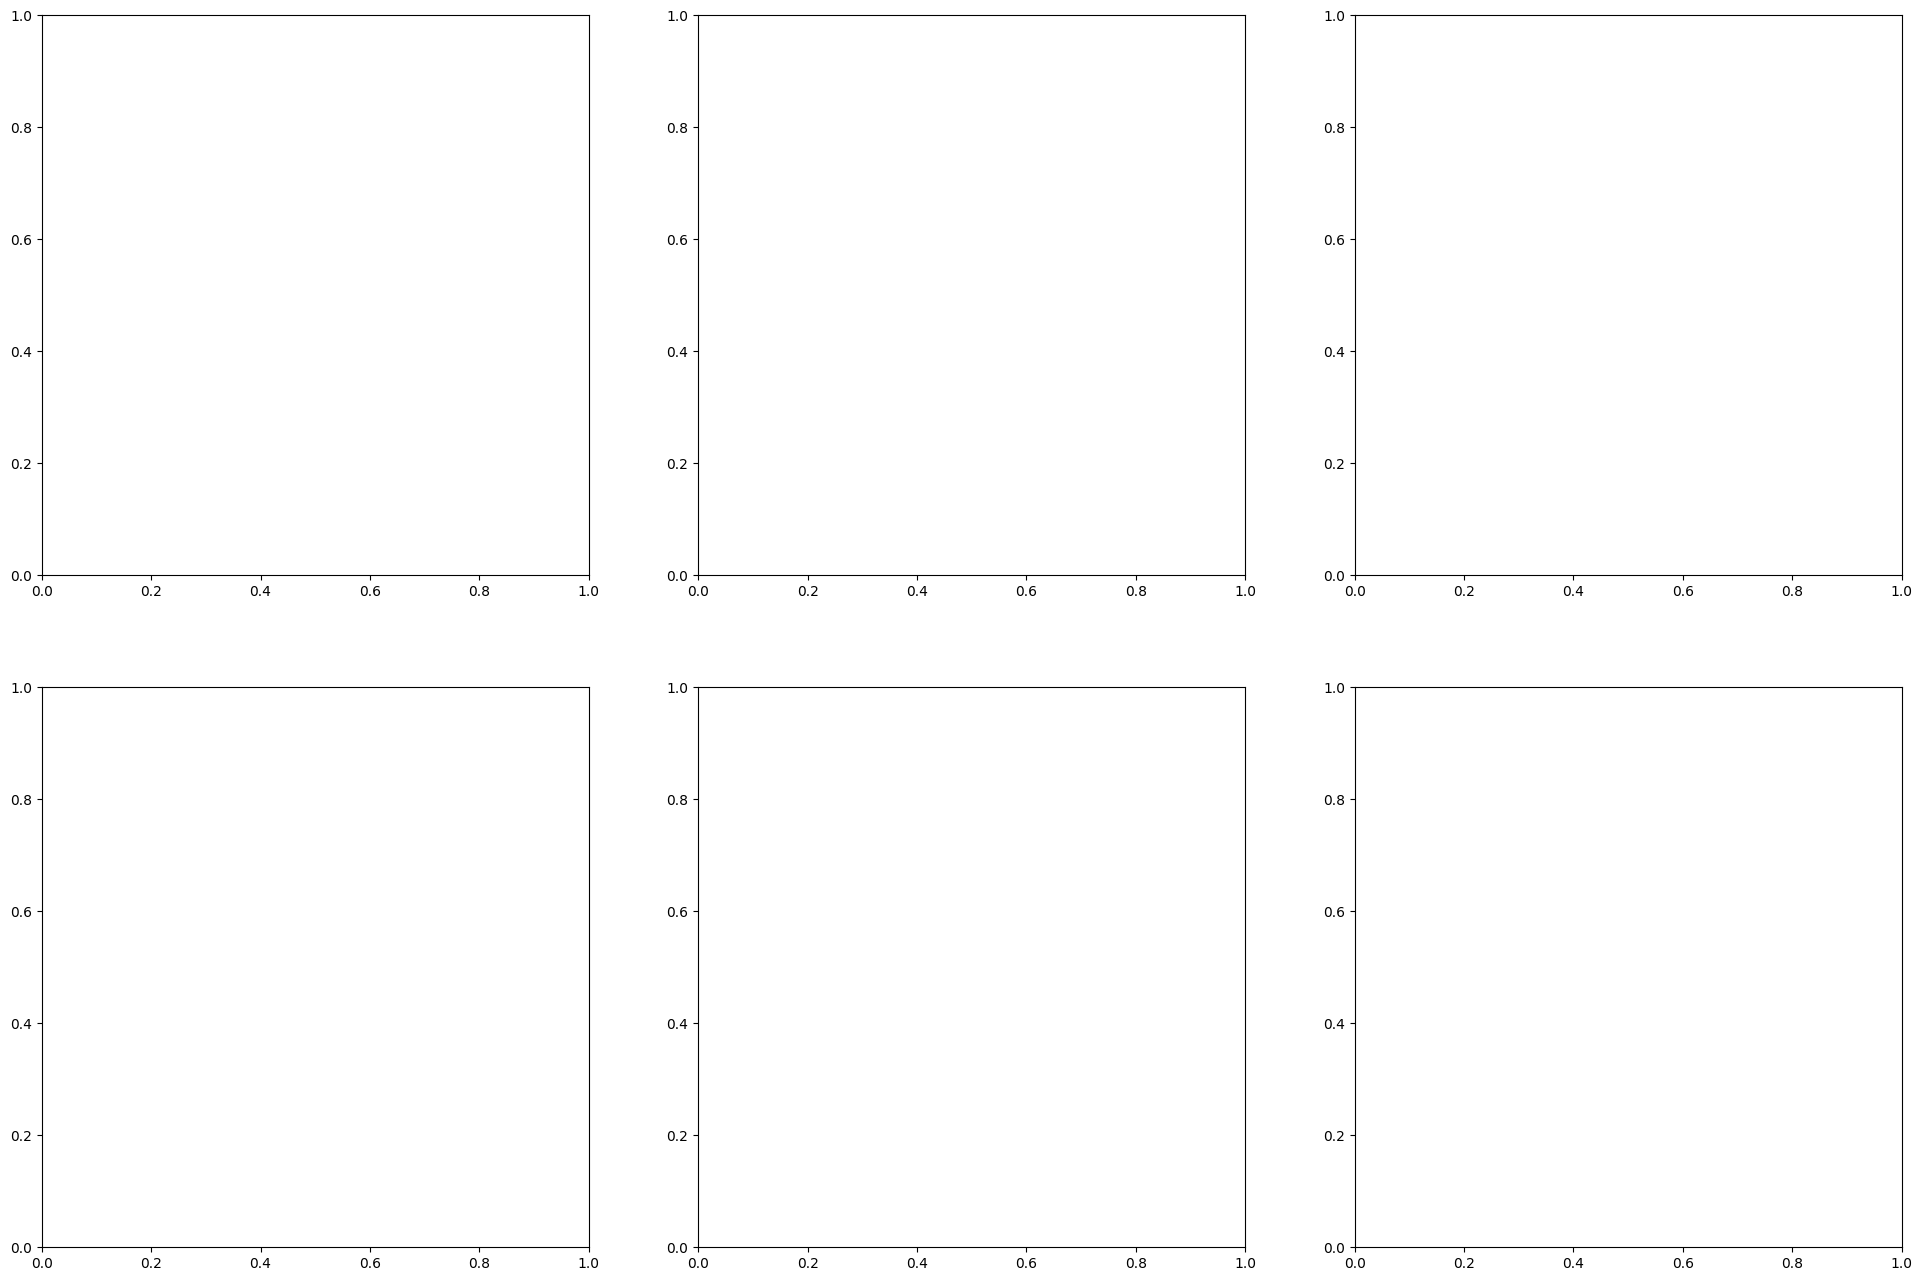

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from zipfile import ZipFile
import pandas as pd
import py7zr

# ============================================================================
# 1. ARRONDISSEMENTS DE PARIS
# ============================================================================
def get_arrondissements_paris():
    """Télécharge les contours des arrondissements de Paris"""
    url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/arrondissements/exports/geojson"
    
    gdf = gpd.read_file(url)
    print(f"✓ Arrondissements chargés : {len(gdf)} unités")
    return gdf

# ============================================================================
# 2. QUARTIERS ADMINISTRATIFS DE PARIS (80 quartiers)
# ============================================================================
def get_quartiers_paris():
    """Télécharge les contours des quartiers administratifs de Paris"""
    url = "https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/quartier_paris/exports/geojson"
    
    gdf = gpd.read_file(url)
    print(f"✓ Quartiers chargés : {len(gdf)} unités")
    return gdf

# ============================================================================
# 3. IRIS DE PARIS - MÉTHODE 1 : via Open Data Île-de-France (RECOMMANDÉE)
# ============================================================================
def get_iris_paris_method1():
    """
    Télécharge les IRIS de Paris via Open Data Île-de-France (GeoJSON)
    MÉTHODE RECOMMANDÉE : Simple et rapide
    """
    url = "https://data.iledefrance.fr/api/explore/v2.1/catalog/datasets/iris/exports/geojson"
    
    print("⏳ Téléchargement des IRIS d'Île-de-France...")
    gdf = gpd.read_file(url)
    
    # Filtrer pour Paris uniquement (codes communes 75101 à 75120)
    gdf_paris = gdf[gdf['depcom'].str.startswith('751')].copy()
    
    print(f"✓ IRIS de Paris chargés : {len(gdf_paris)} unités")
    if 'typ_iris' in gdf_paris.columns:
        print(f"  Types d'IRIS : {gdf_paris['typ_iris'].value_counts().to_dict()}")
    return gdf_paris

# ============================================================================
# 4. IRIS DE PARIS - MÉTHODE 2 : via IGN (fichier 7z)
# ============================================================================
def get_iris_paris_method2():
    """
    Télécharge les IRIS de Paris directement depuis l'IGN
    Format : 7z contenant un shapefile
    """
    # URL directe pour le département 75 (Paris)
    url = "https://data.geopf.fr/telechargement/download/IRIS-GE/IRIS-GE_3-0__SHP_LAMB93_D075_2024-01-01/IRIS-GE_3-0__SHP_LAMB93_D075_2024-01-01.7z"
    
    print("⏳ Téléchargement des IRIS depuis l'IGN (fichier 7z)...")
    response = requests.get(url)
    
    # Extraire le fichier 7z
    with py7zr.SevenZipFile(BytesIO(response.content), mode='r') as z:
        z.extractall(path='temp_iris_ign')
    
    # Charger le shapefile (chercher le fichier .shp)
    import os
    shp_files = [f for f in os.listdir('temp_iris_ign/IRIS-GE_3-0__SHP_LAMB93_D075_2024-01-01') 
                 if f.endswith('.shp')]
    
    if shp_files:
        gdf = gpd.read_file(f'temp_iris_ign/IRIS-GE_3-0__SHP_LAMB93_D075_2024-01-01/{shp_files[0]}')
        print(f"✓ IRIS de Paris chargés : {len(gdf)} unités")
        return gdf
    else:
        print("❌ Fichier shapefile non trouvé dans l'archive")
        return None

# ============================================================================
# 5. IRIS DE PARIS - MÉTHODE 3 : via Opendatasoft (si méthode 1 échoue)
# ============================================================================
def get_iris_paris_method3():
    """
    Alternative via Opendatasoft
    """
    url = "https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-france-iris/exports/geojson?where=dep_code='75'&lang=fr&timezone=Europe%2FParis"
    
    print("⏳ Téléchargement via Opendatasoft...")
    gdf = gpd.read_file(url)
    
    print(f"✓ IRIS de Paris chargés : {len(gdf)} unités")
    return gdf

# Fonction wrapper pour faciliter l'utilisation
def get_iris_paris():
    """
    Télécharge les IRIS de Paris en essayant plusieurs méthodes
    """
    try:
        print("📍 Tentative méthode 1 (Open Data IDF)...")
        return get_iris_paris_method1()
    except Exception as e:
        print(f"⚠️ Méthode 1 échouée : {e}")
        try:
            print("📍 Tentative méthode 3 (Opendatasoft)...")
            return get_iris_paris_method3()
        except Exception as e2:
            print(f"⚠️ Méthode 3 échouée : {e2}")
            print("💡 Essayez : pip install py7zr")
            print("📍 Tentative méthode 2 (IGN avec 7z)...")
            return get_iris_paris_method2()

# ============================================================================
# 6. CARROYAGE INSEE 200m - PARIS
# ============================================================================
def get_carroyage_200m_paris():
    """
    Télécharge le carroyage INSEE 200m pour Paris
    Note : fichier volumineux
    """
    url = "https://www.insee.fr/fr/statistiques/fichier/7655475/car_m.zip"
    
    print("⏳ Téléchargement du carroyage 200m (fichier volumineux, ~500Mo)...")
    response = requests.get(url, stream=True)
    
    with ZipFile(BytesIO(response.content)) as z:
        z.extractall("temp_carroyage_200m")
    
    # Charger le shapefile
    gdf = gpd.read_file("temp_carroyage_200m/car_m.shp")
    
    # Filtrer pour Paris (codes communes 75101 à 75120)
    paris_codes = [f'75{str(i).zfill(3)}' for i in range(101, 121)]
    gdf_paris = gdf[gdf['Depcom'].isin(paris_codes)].copy()
    
    print(f"✓ Carreaux 200m de Paris chargés : {len(gdf_paris)} carreaux")
    return gdf_paris

# ============================================================================
# 7. CARROYAGE INSEE 1km - PARIS
# ============================================================================
def get_carroyage_1km_paris():
    """
    Télécharge le carroyage INSEE 1km pour Paris
    Plus léger que le 200m
    """
    url = "https://www.insee.fr/fr/statistiques/fichier/7655475/car_1km.zip"
    
    print("⏳ Téléchargement du carroyage 1km...")
    response = requests.get(url, stream=True)
    
    with ZipFile(BytesIO(response.content)) as z:
        z.extractall("temp_carroyage_1km")
    
    gdf = gpd.read_file("temp_carroyage_1km/car_1km.shp")
    
    # Filtrer pour Paris
    paris_codes = [f'75{str(i).zfill(3)}' for i in range(101, 121)]
    gdf_paris = gdf[gdf['Depcom'].isin(paris_codes)].copy()
    
    print(f"✓ Carreaux 1km de Paris chargés : {len(gdf_paris)} carreaux")
    return gdf_paris

# ============================================================================
# VISUALISATION COMPARATIVE - VERSION COMPLÈTE
# ============================================================================
def visualiser_maillages(inclure_carroyage=False):
    """
    Crée une figure comparative de TOUS les maillages de Paris
    
    Parameters:
    -----------
    inclure_carroyage : bool
        Si True, inclut le carroyage 1km (attention: téléchargement plus long)
    """
    # Déterminer le nombre de subplots
    if inclure_carroyage:
        fig, axes = plt.subplots(2, 3, figsize=(24, 16))
        axes = axes.flatten()
    else:
        fig, axes = plt.subplots(2, 2, figsize=(20, 16))
        axes = axes.flatten()
    
    # Arrondissements
    print("\n1/5 Chargement des arrondissements...")
    arr = get_arrondissements_paris()
    arr.plot(ax=axes[0], edgecolor='black', facecolor='lightblue', linewidth=2, alpha=0.7)
    axes[0].set_title(f'Arrondissements\n({len(arr)} unités)', 
                      fontsize=16, fontweight='bold', pad=15)
    axes[0].axis('off')
    
    # Ajouter les numéros d'arrondissements
    for idx, row in arr.iterrows():
        centroid = row.geometry.centroid
        # Chercher la colonne du numéro d'arrondissement
        num_col = next((col for col in ['c_ar', 'n_sq_ar', 'l_ar'] if col in arr.columns), None)
        if num_col:
            axes[0].text(centroid.x, centroid.y, str(row[num_col]), 
                        ha='center', va='center', fontsize=10, fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # Quartiers
    print("\n2/5 Chargement des quartiers...")
    qua = get_quartiers_paris()
    qua.plot(ax=axes[1], edgecolor='black', facecolor='lightcoral', linewidth=0.8, alpha=0.7)
    axes[1].set_title(f'Quartiers administratifs\n({len(qua)} unités)', 
                      fontsize=16, fontweight='bold', pad=15)
    axes[1].axis('off')
    
    # IRIS
    print("\n3/5 Chargement des IRIS...")
    iris = get_iris_paris()
    
    # Créer une palette de couleurs par arrondissement pour les IRIS
    import matplotlib.cm as cm
    import numpy as np
    
    # Extraire l'arrondissement du code commune
    if 'depcom' in iris.columns:
        iris['arrondissement'] = iris['depcom'].str[-2:].astype(int)
    elif 'insee_com' in iris.columns:
        iris['arrondissement'] = iris['insee_com'].str[-2:].astype(int)
    else:
        iris['arrondissement'] = 1  # Fallback
    
    colors = cm.tab20(np.linspace(0, 1, 20))
    iris['color'] = iris['arrondissement'].apply(lambda x: colors[x-1] if x <= 20 else colors[0])
    
    iris.plot(ax=axes[2], edgecolor='black', color=iris['color'], linewidth=0.4, alpha=0.6)
    axes[2].set_title(f'IRIS\n({len(iris)} unités)', 
                      fontsize=16, fontweight='bold', pad=15)
    axes[2].axis('off')
    
    # Superposition Arrondissements + IRIS
    print("\n4/5 Création superposition Arrondissements + IRIS...")
    iris.plot(ax=axes[3], edgecolor='gray', facecolor='lightgreen', 
              linewidth=0.3, alpha=0.5)
    arr.plot(ax=axes[3], edgecolor='red', facecolor='none', linewidth=2.5)
    axes[3].set_title('Superposition\nArrondissements (rouge) + IRIS', 
                      fontsize=16, fontweight='bold', pad=15)
    axes[3].axis('off')
    
    # Carroyage ou info
    if inclure_carroyage:
        print("\n5/5 Chargement du carroyage 1km (peut prendre 1-2 minutes)...")
        try:
            car = get_carroyage_1km_paris()
            car.plot(ax=axes[4], edgecolor='navy', facecolor='lightyellow', 
                    linewidth=0.3, alpha=0.6)
            axes[4].set_title(f'Carroyage INSEE 1km\n({len(car)} carreaux)', 
                            fontsize=16, fontweight='bold', pad=15)
            axes[4].axis('off')
            
            # Superposition Carroyage + Arrondissements
            car.plot(ax=axes[5], edgecolor='gray', facecolor='lightyellow', 
                    linewidth=0.2, alpha=0.5)
            arr.plot(ax=axes[5], edgecolor='black', facecolor='none', linewidth=2)
            axes[5].set_title('Superposition\nCarroyage 1km + Arrondissements', 
                            fontsize=16, fontweight='bold', pad=15)
            axes[5].axis('off')
        except Exception as e:
            axes[4].text(0.5, 0.5, f'Erreur de chargement\ndu carroyage:\n{str(e)[:50]}...', 
                        ha='center', va='center', fontsize=11,
                        bbox=dict(boxstyle='round', facecolor='wheat'))
            axes[4].axis('off')
            axes[5].axis('off')
    else:
        # Info carroyage
        axes[3].text(0.5, 0.05, 
                    '💡 Pour voir aussi le carroyage 1km:\nvisualiser_maillages(inclure_carroyage=True)',
                    ha='center', va='bottom', fontsize=11, transform=axes[3].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Titre général
    fig.suptitle('Maillages géographiques de Paris - Comparaison complète', 
                 fontsize=20, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.savefig('maillages_paris_complet.png', dpi=300, bbox_inches='tight')
    print("\n✓ Visualisation sauvegardée : maillages_paris_complet.png")
    plt.show()
    
    return {'arrondissements': arr, 'quartiers': qua, 'iris': iris}

# ============================================================================
# GUIDE D'UTILISATION
# ============================================================================
if __name__ == "__main__":
    print("=" * 70)
    print("MAILLAGES GÉOGRAPHIQUES DE PARIS")
    print("=" * 70)
    
    print("\n1. Pour charger les arrondissements :")
    print("   arr = get_arrondissements_paris()")
    
    print("\n2. Pour charger les quartiers :")
    print("   qua = get_quartiers_paris()")
    
    print("\n3. Pour charger les IRIS (recommandé pour analyses fines) :")
    print("   iris = get_iris_paris()")
    
    print("\n4. Pour le carroyage 200m (très détaillé) :")
    print("   car_200m = get_carroyage_200m_paris()")
    
    print("\n5. Pour le carroyage 1km (intermédiaire) :")
    print("   car_1km = get_carroyage_1km_paris()")
    
    print("\n6. Pour visualiser tous les maillages :")
    print("   visualiser_maillages()")
    
    print("\n" + "=" * 70)
    print("RECOMMANDATIONS PAR CAS D'USAGE")
    print("=" * 70)
    print("• Analyse macro / Communication : Arrondissements (20)")
    print("• Analyse intermédiaire : Quartiers (80)")
    print("• Analyse fine / Sociodémographie : IRIS (~1000)")
    print("• Analyse ultra-fine / Urbanisme : Carroyage 200m")
    print("• Grille régulière neutre : Carroyage 200m ou 1km")
    
    visualiser_maillages(inclure_carroyage=True)